# Numba: don't be afraid of for-loops

A just-in-time (jit) compiler for numpy-based programs.

Useful for
1. cpu-intensive computations
2. programs with many for-loops (use with care)

In [1]:
import numpy as np
from numba import njit

In [2]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"

## Function definition

In [3]:
def f(x):
    return x

In [4]:
f

<function __main__.f(x)>

## Njit

In [5]:
@njit
def f(x):
    return x

In [6]:
f

CPUDispatcher(<function f at 0x7fe6c6fcd6c0>)

## Numba by example: particle-swarm optimisation (PSO)
$$
    f(x,y) = \sin\left(\frac{1}{2}x^2 - \frac{1}{4}y^2 + 3 \right) \cos(2x + 1 - \exp(y))
$$

In [38]:
@njit
def f(X):
    x, y = X
    t1 = np.sin(x ** 2 / 2 - y ** 2 / 4 + 3)
    t2 = np.cos(2 * x + 1 - np.exp(y))
    return t1 * t2

In [39]:
X = np.mgrid[-5:4:0.05, -5:3:0.05]
Z = f(X)

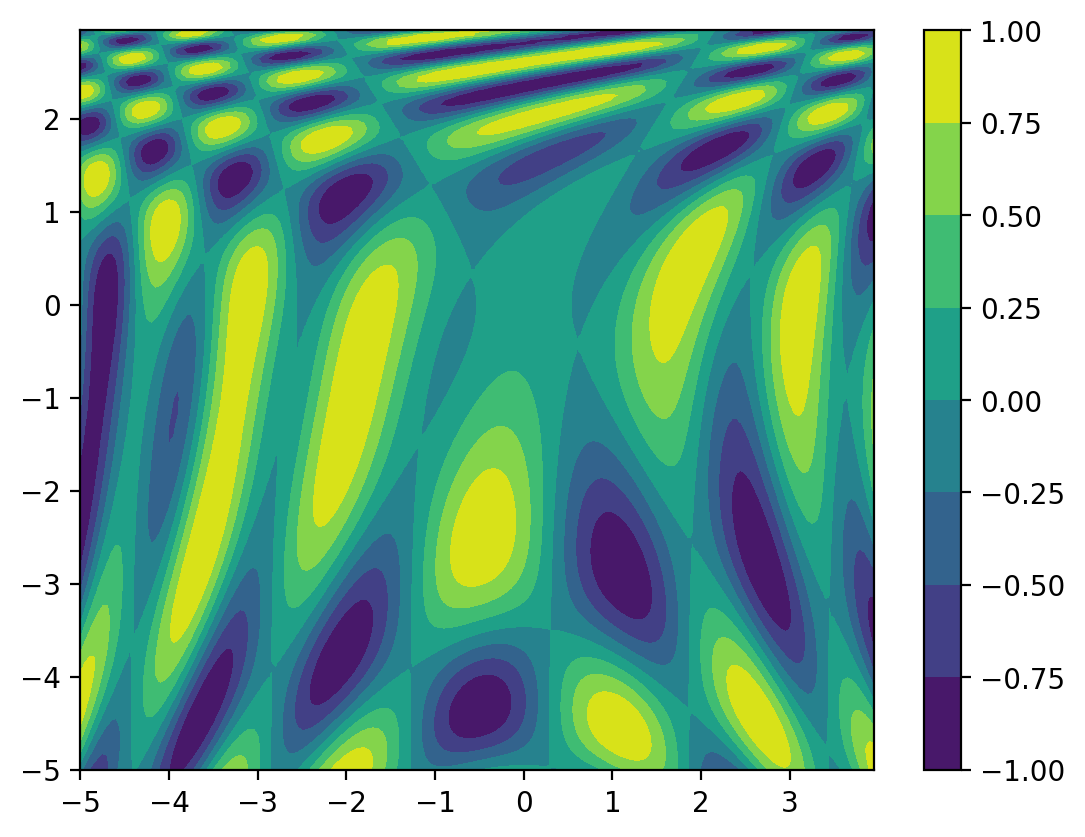

In [40]:
plt.contourf(*X, Z)
plt.colorbar()

## The PSO algorithm

### Initialise

In [98]:
def initialise_swarm(f, dim, b_up, b_down, n_particles):
    v_init = np.abs(b_up - b_down)
    
    positions = np.random.uniform(b_down, b_up, size=(n_particles, dim))
    velocities = np.random.uniform(-v_init, v_init, size=(n_particles, dim))
    positions_best = positions.copy()
    
    position_best_global = positions_best[0]
    position_best_global, f_star = find_best_position(positions, position_best_global, f)

    return (positions, velocities, positions_best), position_best_global

### Update rule

For each particle,
$$
\begin{align*}
    {\bf v}_{n,t+1} &= \omega {\bf v}_{n, t} + \phi_p r_p({\bf p}_{n, t} - {\bf x}_{n, t}) + \phi_g r_g ({\bf g}_{t} - {\bf x}_{n, t})\\
    {\bf x}_{n,t+1} &= {\bf x}_{n,t+1} + \alpha {\bf v}_{n,t+1}\\
    {\bf p}_{n,t+1} &= \begin{cases}
        x_{n, t+1} & f(x_{t, n+1}) < f(p_{t, n})\\
        p_{t, n} & \text{otherwise}
    \end{cases}
\end{align*}
$$

Then,
$$
{\bf g}_{t+1} =
    \begin{cases}
        x_{n, t+1} & f(x_{t, n+1}) < f(g_{t, n})\\
        g_{t} & \text{otherwise}
    \end{cases}
$$


Here,
* $\omega$ is the influence of previous velocity
* $\phi_p$ is the cognitive effect factor
* $\phi_g$ is the social influece factor
* $\alpha$ is the learning_rate
* $r_p \sim {\cal U}[0, 1]$
* $r_g \sim {\cal U}[0, 1]$

## The code

In [171]:
@njit
def find_best_position(best_positions, g_current, f):
    g_new = g_current.copy()
    for ix, position in enumerate(best_positions):
        if f(position) < f(g_current):
            g_new = position.copy()
    return g_new, f(g_new)


@njit
def update_particle(
    pos, vel, pos_best, pos_best_global,
    omega, phi_p, phi_g, alpha, f
):
    # rp, rg = np.random.uniform(size=2)
    rp = np.random.uniform()
    rg = np.random.uniform()
    
    vel_new = omega * vel + phi_p * rp * (pos_best - pos) + phi_g * rg * (pos_best_global - pos)
    pos_new = pos + alpha * vel_new

    if f(pos_new) < f(pos_best):
        pos_best_new = pos_new
    else:
        pos_best_new = pos_best

    return pos_new, vel_new, pos_best_new


@njit
def update_particles(
    positions, velocities, positions_best, position_best_global,
    omega, phi_p, phi_g, alpha, f
):
    positions = positions.copy()
    velocities = velocities.copy()
    positions_best = positions_best.copy()
    
    for n, (pos, vel, pos_best) in enumerate(zip(positions, velocities, positions_best)):
        pos_new, vel_new, pos_best_new = update_particle(
            pos, vel, pos_best, position_best_global,
            omega, phi_p, phi_g, alpha, f
        )
        positions[n] = pos_new
        velocities[n] = vel_new
        positions_best[n] = pos_best_new

    return positions, velocities, positions_best

@njit
def run_pso(f, n_particles, dim, timesteps, positions, velocities, positions_best, position_best_global,
            omega, phi_p, phi_g, alpha, seed=314):
    positions_hist = np.zeros((timesteps, n_particles, dim))
    f_star_hist = np.zeros(timesteps)
    position_best_global_hist = np.zeros((timesteps, dim))
    
    for t in range(timesteps):
        np.random.seed(seed + t)
        positions, velocities, positions_best = update_particles(
            positions, velocities, positions_best, position_best_global,
            omega, phi_p, phi_g, alpha, f
        )
        
        find_best_position(positions, position_best_global, f)
        
        position_best_global, f_star = find_best_position(positions, position_best_global, f)
    
        positions_hist[t] = positions
        position_best_global_hist[t] = position_best_global
        f_star_hist[t] = f_star

    hist = positions_hist, position_best_global_hist, f_star_hist
    return positions_best, hist

In [172]:
influence_vel = 0.01 # ω
cognitive_effect = 0.01 # ϕp
social_influence = 0.05 # ϕg
learning_rate = 0.4#0.9 # α

dim = 2

In [173]:
# Initialisiation
n_particles = 10
b_down, b_up = -5, 2.5

np.random.seed(314)
(positions, velocities, positions_best), position_best_global = initialise_swarm(f, dim, b_down, b_up, n_particles)

In [174]:
timesteps = 1000

In [176]:
positions_best, hist = run_pso(
    f, n_particles, dim, timesteps, positions, velocities, positions_best, position_best_global,
    influence_vel, cognitive_effect, social_influence, learning_rate
)
positions_hist, position_best_global_hist, f_star_hist = hist

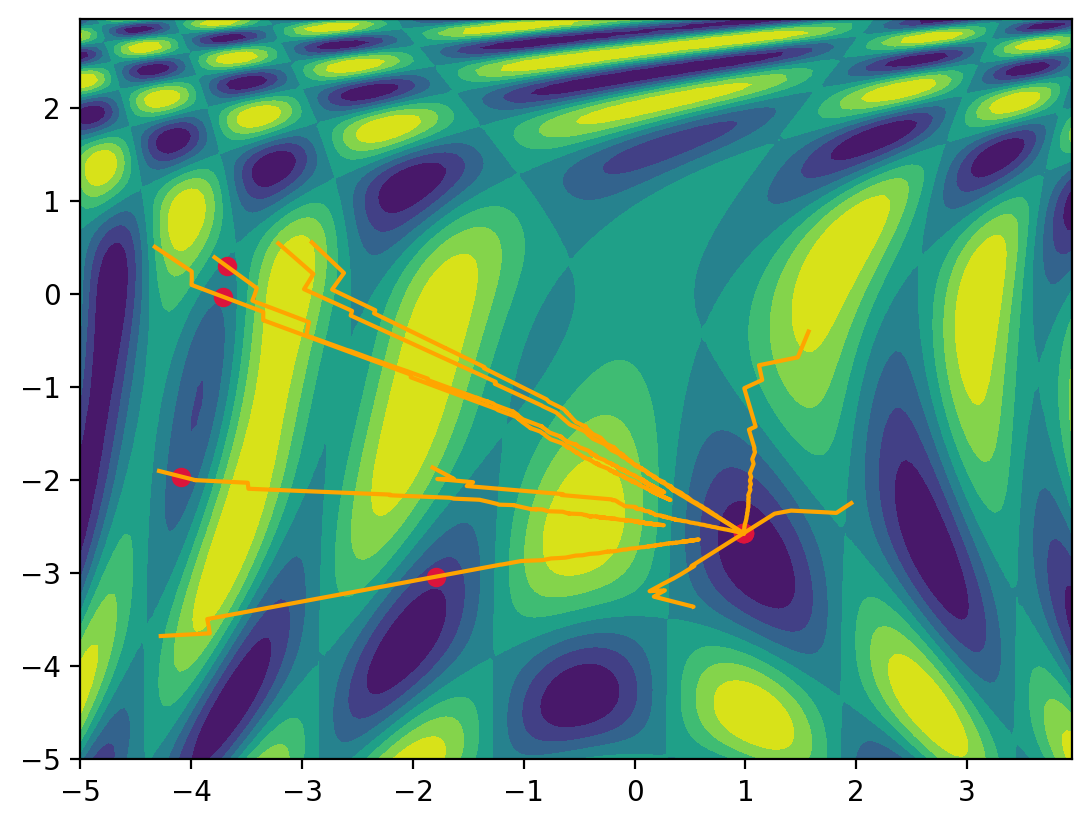

In [177]:
plt.contourf(*X, Z)

for p in range(n_particles):
    plt.plot(*positions_hist[:, p, :].T, c="orange")

plt.scatter(*positions_best.T, c="crimson")

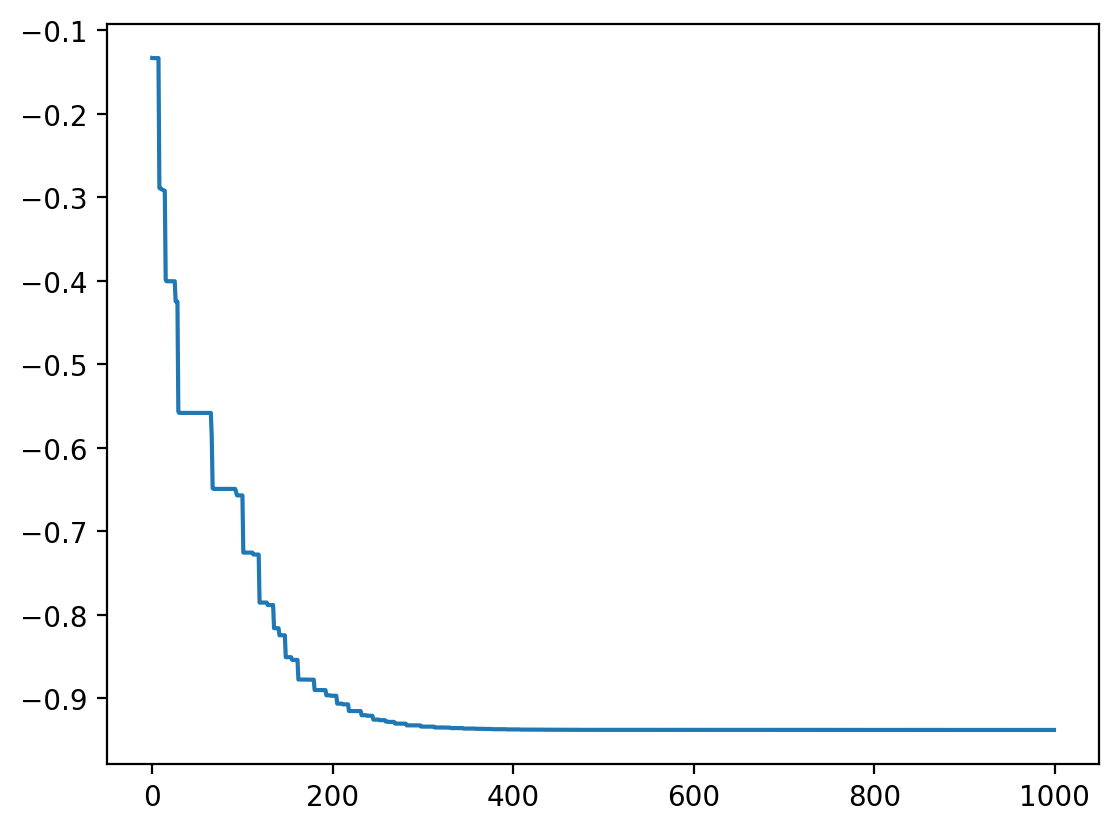

In [178]:
plt.plot(f_star_hist)

## Example: training a neural network with the particle swarm optimisator (PSO)

In [179]:
@njit
def fv(x):
    return 0.4 + 0.1 * x - 1.2 + np.sin(x) * x

In [180]:
n_samples = 200
np.random.seed(3141)
x = np.random.uniform(-5, 5, n_samples)
errs = np.random.randn(n_samples) * 0.4
y = fv(x) + errs

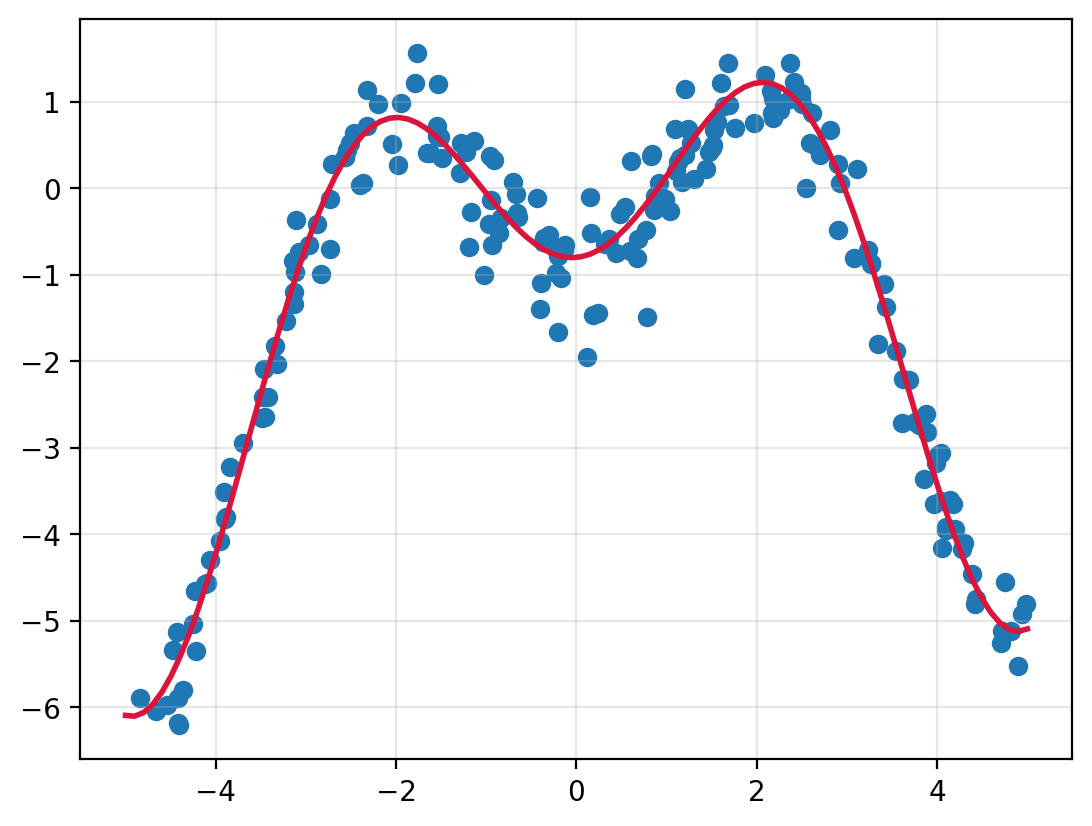

In [181]:
xrange = np.linspace(-5, 5, 100)
plt.plot(xrange, fv(xrange), c="crimson", linewidth=2)
plt.scatter(x, y)
plt.grid(alpha=0.3)

In [182]:
@njit
def mlp(weights, x):
    wl1 = weights[:10]
    b1 = weights[10]
    wl2 = weights[11:-3]
    b2 = weights[-3]
    wl3 = weights[-2]
    b3 = weights[-1]

    # l1 = np.tanh(wl1.reshape(10, 1) @ x + b1)
    l1 = np.tanh(wl1[:, None] @ x + b1)
    l2 = np.tanh(wl2[None, :] @ l1 + b2)
    out = wl3 * l2.reshape(1, -1) + b3
    return out

In [183]:
dim = 11 + 11 + 2
w = np.random.randn(dim)

In [184]:
@njit
def lossfn(weights):
    return np.sqrt(np.power(y - mlp(weights, x[None, :]).ravel(), 2).mean())

In [185]:
lossfn(w)

2.813767302242264

## Train with swarm

In [226]:
influence_vel = 0.01 # ω
cognitive_effect = 0.01 # ϕp
social_influence = 0.05 # ϕg
learning_rate = 0.4 # α

In [227]:
# Initialisiation
n_particles = 100
b_down, b_up = -5, 5

np.random.seed(314)
(positions, velocities, positions_best), position_best_global = initialise_swarm(lossfn, dim, b_down, b_up, n_particles)

In [228]:
timesteps = 1000

In [ ]:
%%time
positions_best, hist = run_pso(
    lossfn, n_particles, dim, timesteps, positions, velocities, positions_best, position_best_global,
    influence_vel, cognitive_effect, social_influence, learning_rate
)
positions_hist, position_best_global_hist, f_star_hist = hist

In [ ]:
plt.plot(f_star_hist)

In [ ]:
w_star = position_best_global_hist[-1]

In [ ]:
yhat = mlp(w_star, xrange[None, :]).ravel()

In [ ]:
xrange = np.linspace(-5, 5, 100)
plt.plot(xrange, fv(xrange), c="crimson", linewidth=2, label="ground truth")
plt.plot(xrange, yhat, c="tab:orange", label="MLP")
plt.scatter(x, y, c="none", edgecolor="gray")
plt.legend()
plt.grid(alpha=0.3)